In [10]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
from matplotlib.lines import Line2D
sizeTitle = 24
sizeAxis = 14

### Dataset

The data we are going to use consists of [single-cell](https://en.wikipedia.org/wiki/Single-cell_analysis) [qPCR](https://en.wikipedia.org/wiki/Real-time_polymerase_chain_reaction) data for 48 genes obtained from mice (Guo *et al.*, [1]). This data is available at the [Open Data Science repository](https://github.com/sods/ods). The data contains 48 columns, with each column corresponding to (normalized) measurements of each gene. Cells differentiate during their development and these data were obtained at various stages of development. The various stages are labelled from the 1-cell stage to the 64-cell stage. For the 32-cell stage, the data is further differentiated into 'trophectoderm' (TE) and 'inner cell mass' (ICM). ICM further differentiates into 'epiblast' (EPI) and 'primitive endoderm' (PE) at the 64-cell stage. Each of the rows in the dataset is labelled with one of these stages.

In [11]:
# license: Copyright (c) 2014, the Open Data Science Initiative
# license: https://www.elsevier.com/legal/elsevier-website-terms-and-conditions
URL = "https://raw.githubusercontent.com/sods/ods/master/datasets/guo_qpcr.csv"

df = pd.read_csv(URL, index_col=0)
print("Data shape: {}\n{}\n".format(df.shape, "-" * 21))
print("Data labels: {}\n{}\n".format(df.index.unique().tolist(), "-" * 86))
df.head()

Data shape: (437, 48)
---------------------

Data labels: ['1', '2', '4', '8', '16', '32 TE', '32 ICM', '64 PE', '64 TE', '64 EPI']
--------------------------------------------------------------------------------------



,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985


# T-SNE

In [12]:
df_T=df
labels = df.index.unique()

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 437 samples in 0.000s...
[t-SNE] Computed neighbors for 437 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 437 / 437
[t-SNE] Mean sigma: 1.297417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.220642
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


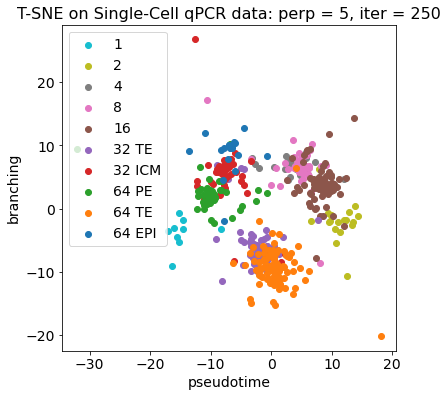

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 437 samples in 0.000s...
[t-SNE] Computed neighbors for 437 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 437 / 437
[t-SNE] Mean sigma: 1.297417


KeyboardInterrupt: 

In [17]:
#Heat-map + grid search
iterations = [250,300,400,500,700,800,1000,1200]
perplexity = [5,10,15,20,25,30,35,40,45,50,80]
scores_tsneonly = np.zeros((len(iterations),len(perplexity)))
scores_tsneonly_avg = np.zeros((len(iterations),len(perplexity)))
for i in range(10):
    for idxp,perp in enumerate(perplexity):
        for idxi,iter in enumerate(iterations):
            #t-SNE
            tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=iter)
            tsne_results = tsne.fit_transform(df_T.iloc[:,:-1].values)
            #Classification with kNN
            classifier=KNeighborsClassifier(n_neighbors=5)
            data_tr, data_te, label_tr, label_te = model_selection.train_test_split(tsne_results, df.index, train_size = 0.6)
            model = classifier.fit(data_tr, label_tr)
            scores_tsneonly[idxi][idxp] = model.score(data_te, label_te)
            #Plotting t-SNE embeddings
            fig = plt.figure(figsize=(6, 6))
            matplotlib.rcParams.update({'font.size':sizeAxis})
            for i, label in enumerate(labels):
                X_i = tsne_results[df.index == label]
                plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)
            plt.legend()
            plt.xlabel("pseudotime", fontsize=14)
            plt.ylabel("branching", fontsize=14)
            plt.title('T-SNE on Single-Cell qPCR data: perp = %d' %(perp)+', iter = %d' %(iter), fontsize=16)
            plt.show()
         
    scores_tsneonly_avg +=scores_tsneonly
scores_tsneonly_avg = scores_tsneonly_avg/10
#Plotting heat-map
matplotlib.rcParams.update({'font.size': 14})
plt.imshow(scores_tsneonly_avg)

ax = plt.gca();
ax.set_xticks(np.arange(0, 11, 1));
ax.set_yticks(np.arange(0, 8, 1));
ax.set_xticklabels(perplexity);
ax.set_yticklabels(iterations);

cbar = plt.colorbar()
cbar.set_label('Test classification accuracy')
plt.xlabel('Perplexity')
plt.ylabel('Number of iterations')
plt.title 

In [14]:
#t-SNE output with a single set of parameters
tsne = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000)
tsne_results = tsne.fit_transform(df_T.iloc[:,:-1].values)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 437 samples in 0.000s...
[t-SNE] Computed neighbors for 437 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 437 / 437
[t-SNE] Mean sigma: 2.465115
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.201626
[t-SNE] KL divergence after 1000 iterations: 0.373418


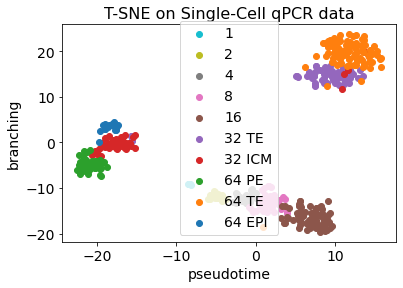

In [15]:
#Plotting t-SNE resulting embedding
for i, label in enumerate(labels):
    X_i = tsne_results[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)
plt.legend()
plt.xlabel("pseudotime", fontsize=14)
plt.ylabel("branching", fontsize=14)
plt.title("T-SNE on Single-Cell qPCR data", fontsize=16)
plt.show()